Cel projektu: Przewidywanie poziomu ryzyka wypadku (accident_risk) na podstawie parametrów infrastruktury drogowej (np. road_type, speed_limit) oraz warunków zewnętrznych (np. weather, lighting).

Źródło danych: https://www.kaggle.com/datasets/chetanmittal033/road-accident-dataset

Do projektu wycięto 10 tysięcy danych ze zbioru train.csv.

In [72]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

In [73]:
df = pd.read_csv("./archive/data.csv", encoding='utf-16')

In [74]:
df.head(5)

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


In [75]:
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      10000 non-null  int64  
 1   road_type               10000 non-null  object 
 2   num_lanes               10000 non-null  int64  
 3   curvature               10000 non-null  float64
 4   speed_limit             10000 non-null  int64  
 5   lighting                10000 non-null  object 
 6   weather                 10000 non-null  object 
 7   road_signs_present      10000 non-null  bool   
 8   public_road             10000 non-null  bool   
 9   time_of_day             10000 non-null  object 
 10  holiday                 10000 non-null  bool   
 11  school_season           10000 non-null  bool   
 12  num_reported_accidents  10000 non-null  int64  
 13  accident_risk           10000 non-null  float64
dtypes: bool(4), float64(2), int64(4), objec

id                        0
road_type                 0
num_lanes                 0
curvature                 0
speed_limit               0
lighting                  0
weather                   0
road_signs_present        0
public_road               0
time_of_day               0
holiday                   0
school_season             0
num_reported_accidents    0
accident_risk             0
dtype: int64

Rozkłady zmiennej celu (y = accident_risk) oraz zmiennych objaśniających numerycznych

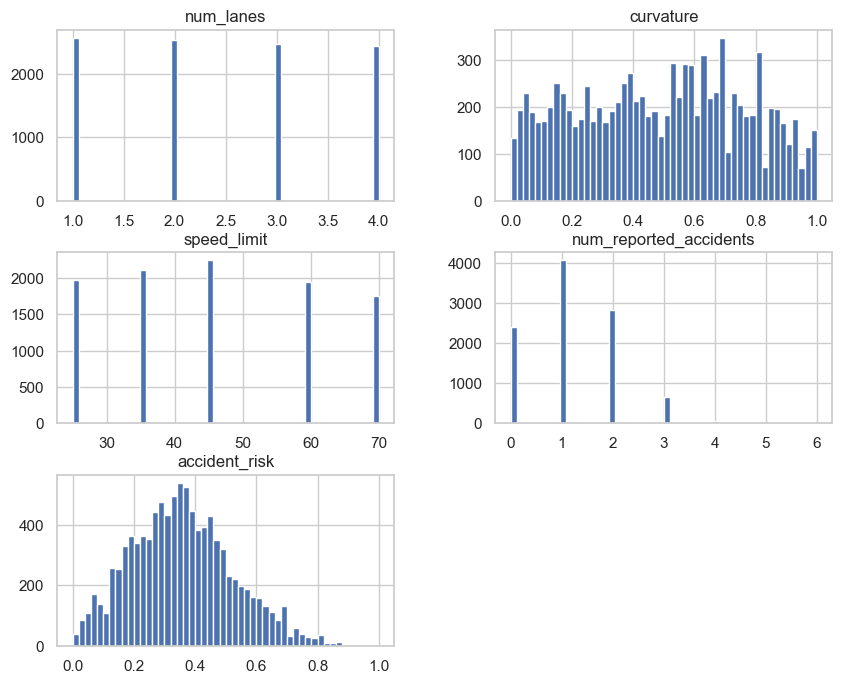

In [76]:
df.hist(bins=50, figsize=(10,8), column=[col for col in df.columns if col != 'id'])
plt.show()

Rozkład ryzyka jest zbliżony do normalnego, jednak widać lekką asymetrię prawostronną. Większość dróg ma niskie lub średnie ryzyko, a ekstremalnie niebezpieczne odcinki są rzadsze, co jest naturalne dla rzeczywistych danych drogowych.

Rozkłady zmiennych objaśniających kategorycznych

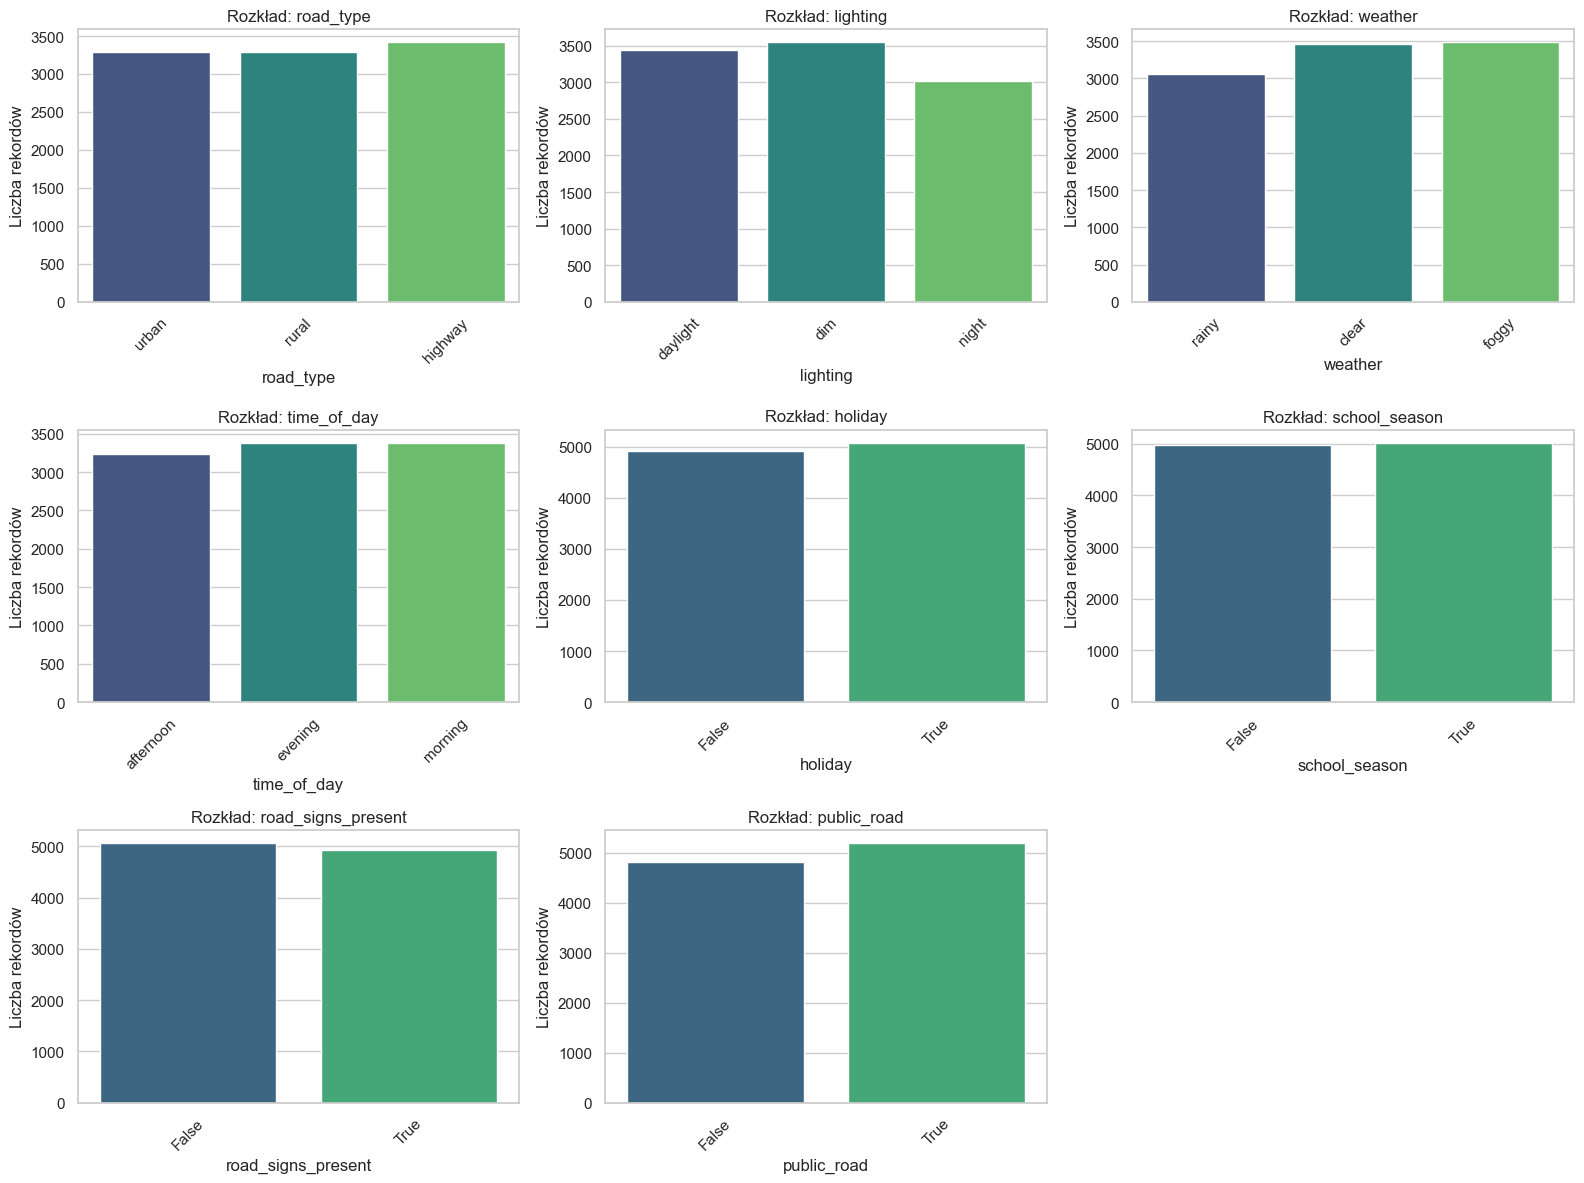


Statystyki dla road_type:
road_type
highway    3416
urban      3292
rural      3292
Name: count, dtype: int64

Statystyki dla lighting:
lighting
dim         3544
daylight    3434
night       3022
Name: count, dtype: int64

Statystyki dla weather:
weather
foggy    3483
clear    3462
rainy    3055
Name: count, dtype: int64

Statystyki dla time_of_day:
time_of_day
morning      3382
evening      3378
afternoon    3240
Name: count, dtype: int64

Statystyki dla holiday:
holiday
True     5077
False    4923
Name: count, dtype: int64

Statystyki dla school_season:
school_season
True     5017
False    4983
Name: count, dtype: int64

Statystyki dla road_signs_present:
road_signs_present
False    5063
True     4937
Name: count, dtype: int64

Statystyki dla public_road:
public_road
True     5192
False    4808
Name: count, dtype: int64


In [77]:
# 1. Definicja kolumn kategorycznych
# Wybieramy te, które mają typ 'object' lub są logiczne (bool)
categorical_cols = ['road_type', 'lighting', 'weather', 'time_of_day', 
                    'holiday', 'school_season', 'road_signs_present', 'public_road']

# 2. Tworzenie zbiorczego wykresu dla zmiennych kategorycznych
plt.figure(figsize=(16, 12))
plt.subplots_adjust(hspace=0.5)

for i, col in enumerate(categorical_cols):
    plt.subplot(3, 3, i + 1)
    # countplot pokazuje liczebność każdej kategorii
    sns.countplot(data=df, x=col, palette='viridis', hue=col, legend=False)
    plt.title(f'Rozkład: {col}')
    plt.xticks(rotation=45)
    plt.ylabel('Liczba rekordów')

plt.tight_layout()
plt.show()

# 3. Wyświetlenie dokładnych wartości liczbowych w konsoli
for col in categorical_cols:
    print(f"\nStatystyki dla {col}:")
    print(df[col].value_counts())

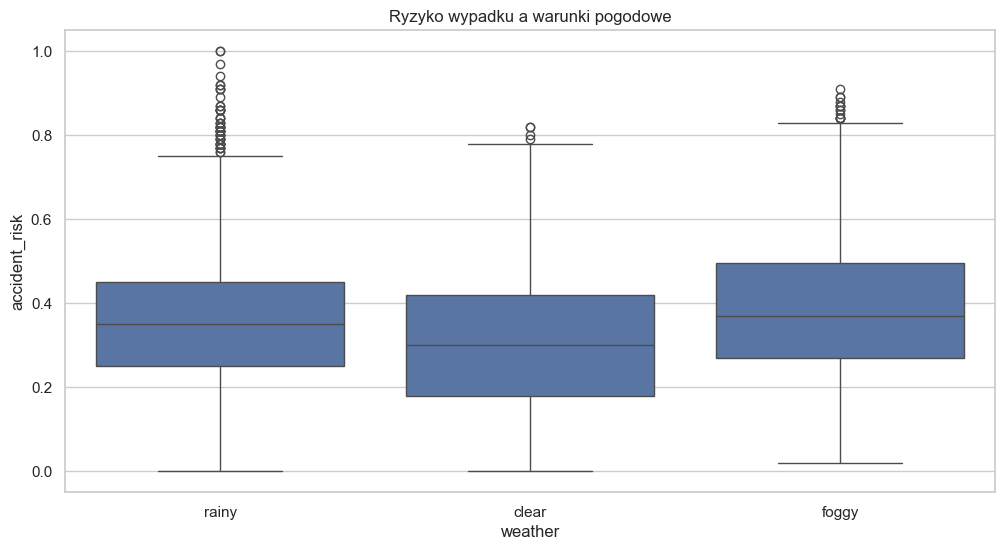

In [78]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='weather', y='accident_risk', data=df)
plt.title('Ryzyko wypadku a warunki pogodowe')
plt.show()

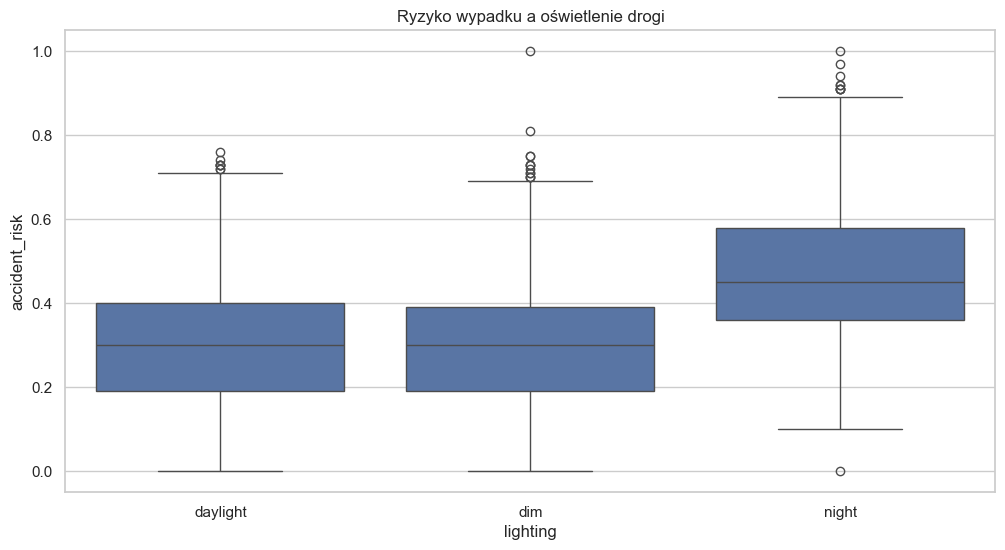

In [79]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='lighting', y='accident_risk', data=df)
plt.title('Ryzyko wypadku a oświetlenie drogi')
plt.show()

Analiza wykresu pudełkowego dla zmiennej lighting wykazała istotne różnice w rozkładzie ryzyka. Mediana ryzyka dla warunków nocnych (night) jest o ok. 15% wyższa niż w przypadku światła dziennego. Dodatkowo, warunki nocne charakteryzują się większą zmiennością (szersze pudełko), co sugeruje, że brak oświetlenia jest jednym z kluczowych czynników wpływających na niepewność modelu. Punkty nad "wąsami" (outliery) to wartości odstające. Pokazują one, że nawet w dzień (daylight) zdarzają się sytuacje o bardzo wysokim ryzyku (powyżej 0.7), mimo że typowe ryzyko jest niskie.

<Axes: xlabel='curvature', ylabel='accident_risk'>

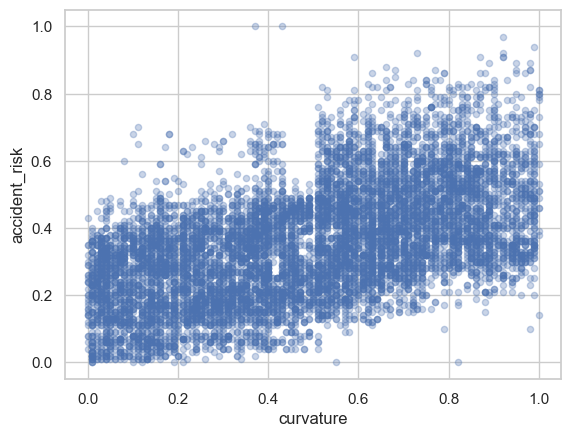

In [80]:
df.plot(kind='scatter', x='curvature',y='accident_risk', alpha=0.3)

Wykres rozrzutu z linią regresji wykazuje wyraźną korelację dodatnią między zakrzywieniem drogi a ryzykiem wypadku. Sugeruje to, że bardziej kręte odcinki dróg są trudniejsze dla kierowców i generują wyższe prawdopodobieństwo zdarzeń drogowych.

<Axes: xlabel='speed_limit', ylabel='accident_risk'>

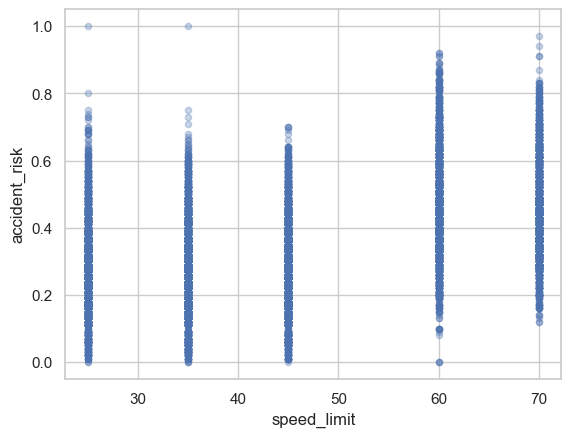

In [81]:
df.plot(kind='scatter', x='speed_limit',y='accident_risk', alpha=0.3)

Istnieje wyraźna dodatnia korelacja między dopuszczalną prędkością a ryzykiem wypadku.

<Axes: >

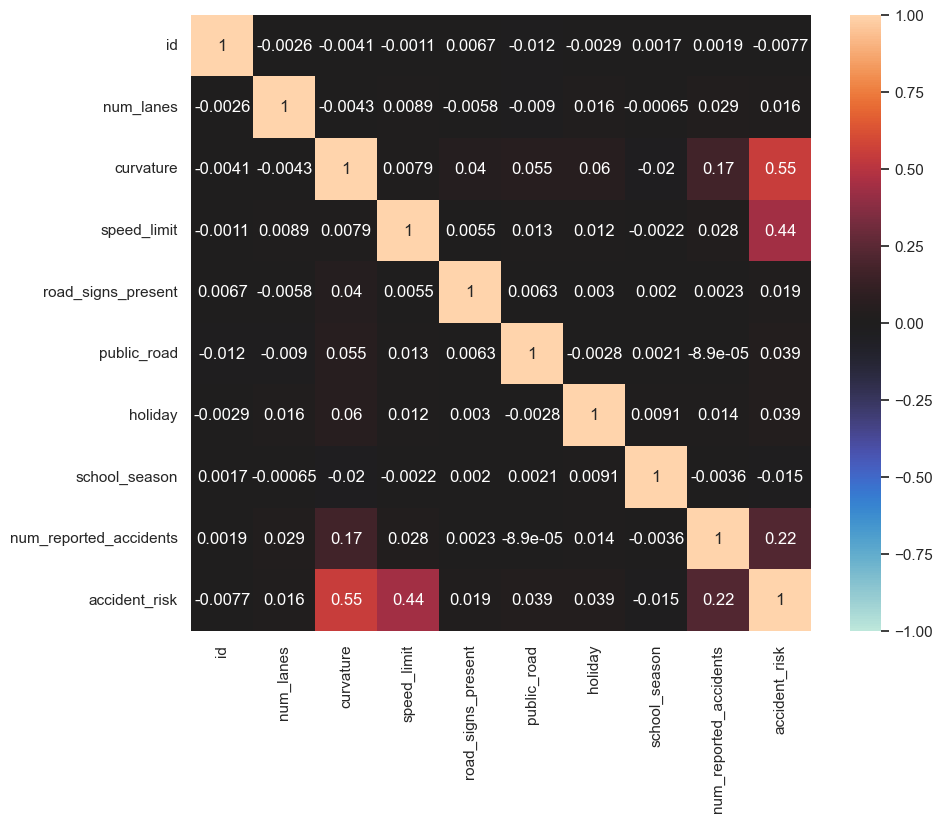

In [82]:
plt.figure(figsize=(10,8))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, vmin=-1, center=0, vmax=1, annot=True)

Kolejno krzywizna drogi oraz ograniczenie prędkości mają najsilniejszy wpływ na ryzyko.